In [ ]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
import torch
import sklearn
from WeaponData import WeaponData
from cnn import CnnNet
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import adaptive_leraning_rate
import shap

%config InlineBackend.figure_format = 'svg'



In [ ]:
dataset = WeaponData()


In [ ]:
net = CnnNet(86, len(dataset.classes),  c_kernels=[7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5], in_channels=[
             3, 16, 32, 64, 86, 128, 128, 128, 128, 128, 128, 128], out_channels=[16, 32, 64, 86, 128, 128, 128, 128, 128, 128, 128, 128])
criterion = nn.NLLLoss()
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_test = []


In [ ]:
if torch.cuda.is_available():
    net = net.cuda()
    net.cnn = net.cnn.cuda()
    print("GPU is available")
else:
    torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
def test(dataset, model, criterion):
    total = 0.
    predicted = 0.
    loss_test = 0.
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, labels in dataset.testloader:
            labels = labels.cuda()
            data = data.cuda()
            out = model(data)
            predicted_output = torch.argmax(out, dim=1)

            y_true = np.append(y_true, labels.cpu().detach().numpy(), 0)
            y_pred = np.append(y_pred, predicted_output.cpu().detach().numpy(), 0)
            total += labels.shape[0]
            predicted += torch.sum(predicted_output == labels).cpu().item()

            loss = criterion(out, labels)
            loss_test += loss.cpu().item()
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    return (predicted/total*100), loss_test, confusion_matrix

In [ ]:

old_loss = 0
loss_training = []
for e in range(1):
    old_param = net.parameters

    loss_temp = 0
    # pass through all data
    for data, exp in dataset.trainloader:
        exp = exp.cuda()
        # pass data to cuda
        data = data.cuda()
        # clear gradient from previous epoch
        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, exp)
        loss.backward()
        loss_temp += loss.item()
        optimizer.step()

    loss_training.append(loss_temp)
    acc, loss_test, mat = test(dataset, net, criterion)
    net, optimizer = adaptive_leraning_rate(loss_training[-1], optimizer, net, old_param, old_loss)
    old_loss = loss_training[-1]

    ax= plt.subplot()
    sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not_gun', 'gun']); ax.yaxis.set_ticklabels(['not_gun', 'gun']);
    plt.show()
    
    temp_lr: float = optimizer.param_groups[0]['lr']
    print("acc: {:.2f} %".format(acc))
    print("Learning rate: {:.10f}".format(temp_lr))
    print("Epoch: {}.............".format(e), end=" ")
    print("Loss: {:.4f}".format(loss))



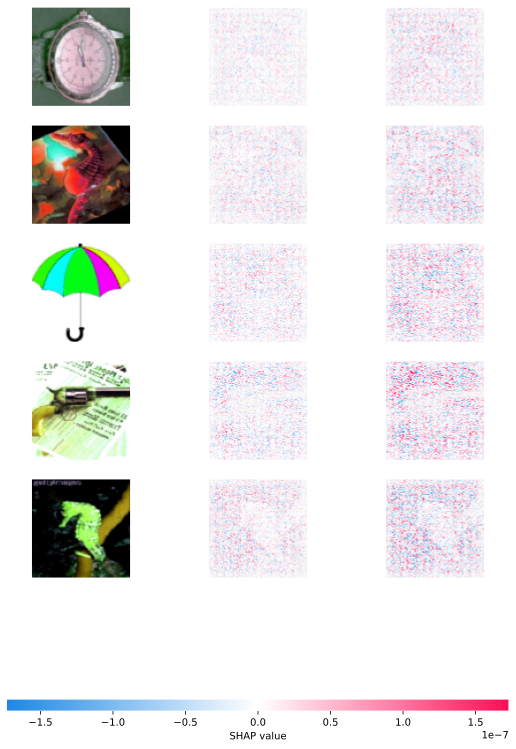

In [21]:
batch = next(iter(dataset.testloader))
images, _ = batch
images = images.view(-1, 3, 86, 86)

background = images[15:]
test_images = images[15:]

e = shap.DeepExplainer(net, background.cuda())
shap_values = e.shap_values(test_images.cuda())

for b_index,b in enumerate(test_images):
    for c_index,c in enumerate(b):
        test_images[b_index, c_index] -= c.min()
        test_images[b_index, c_index] /= (c.max() - c.min())
        test_images[b_index, c_index] = torch.nan_to_num(test_images[b_index, c_index])

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy)